[<img src=https://www.continuum.io/sites/all/themes/continuum/assets/images/logos/logo-horizontal-large.svg width="250">](https://www.continuum.io/ "Superpowers For People Who Change the World")

\begin{center}
\vspace{4cm}
\Huge{Automation of spectral analysis}\\
\large{Author: Bc. Miroslav \textsc{Burda}, OSRAM Czech Republic}
\vfill
\Large{Technical Report}\\
\normalsize{Powered by \textit{Python} and \LaTeX}
\end{center}
\clearpage

# Theoretical preparation

## Importing of necessary libraries and formatting

In [1]:
from IPython.display import IFrame, display, HTML
display(HTML("<style>.container{width:95%;}</style>"))

## Color Rendering Index *(CRI)*

We need little bit adjust the raw spectral data which are measured on machine in production even in laboratory.
We will use for obtaining of the necessary parameters following technical report as a study material.

In [2]:
# Document: CIE 15: Technical Report: Colorimetry, 3rd edition
# CFR Section(s): 10 CFR 430 Subpart B, App. R, 4.1.1
# Standards Body: International Commission on Illumination
# ISBN 3 901 906 33 9

IFrame("./CRI-Data/repository/CIE_15-2004_Colorimetry.pdf",
       width='100%', height=500)

# Implementation and testing

## Importing of necessary libraries

In [3]:
import sys, os, re, math
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from scipy.interpolate import splev, splrep

#from sympy import init_session, pprint
#init_session(quiet=True, use_latex=True)
#%matplotlib inline

## Data loading and Interpolation

**Source: data.CSV (HTI 1400W/PS) - Data from laboratory**

* This block uses accurate data which was measured in laboratory

In [4]:
## Definition of visible light spectrum (resolution - 1nm):
wavelength = np.arange(360,831,1)

## Loading raw Spectrum Data
rawData = pd.read_csv('./CRI-Data/lab/Test-01/1280.SPD',
                      names=['XData', 'YData'], sep='\t')

## Interpolation of raw Spectrum Data (360,380,1)
tck = splrep(rawData.XData, rawData.YData)
lux = splev(wavelength, tck)

## Creating DataFrame of interpolated Spectrum
spectrum = pd.DataFrame({'wavelength':wavelength,'lux':lux})

## Clear memory
del tck, lux, rawData

## Loading of wave functions XYZ
XYZ = pd.read_csv('./CRI-Data/csv/xyz.csv',
                 names=['wavelength','X','Y','Z'], sep='\t')

## Loading of Munsell color functions TCS01 - TCS15
Munsell = pd.read_csv('./CRI-Data/csv/munsell.csv',
                     names=['wavelength',
                            'TCS01','TCS02','TCS03',
                            'TCS04','TCS05','TCS06',
                            'TCS07','TCS08','TCS09',
                            'TCS10','TCS11','TCS12',
                            'TCS13','TCS14','TCS15',], sep='\t')

## Loading of raw functions of reference source
rawRef = pd.read_csv('./CRI-Data/csv/reference.csv',
                 names=['wavelength','S0','S1','S2'], sep=';')

## Interpolation of raw reference functions (360,380,1)
tck = splrep(rawRef.wavelength, rawRef.S0)
S0 = splev(wavelength, tck)
tck = splrep(rawRef.wavelength, rawRef.S1)
S1 = splev(wavelength, tck)
tck = splrep(rawRef.wavelength, rawRef.S2)
S2 = splev(wavelength, tck)

## Creating DataFrame of interpolated reference functions
Ref = pd.DataFrame({'wavelength':wavelength,
                    'S0':S0,'S1':S1,'S2':S2})

## Clear memory
del tck, rawRef

## Spectral calculation and creation of Reference source

In [5]:
radiant = sum(spectrum.lux*XYZ.Y)
flux = radiant * 683

## Normalized spectrum
spectrum.lux = (spectrum.lux/sum(spectrum.lux*XYZ.Y))*100

Xt = sum(XYZ.X*spectrum.lux)
Yt = sum(XYZ.Y*spectrum.lux)
Zt = sum(XYZ.Z*spectrum.lux)

xt = Xt / (Xt + Yt + Zt)
yt = Yt / (Xt + Yt + Zt)
zt = Zt / (Xt + Yt + Zt)

ut = 4*Xt / (Xt + 15*Yt + 3*Zt)
vt = 6*Yt / (Xt + 15*Yt + 3*Zt)
# Attention, newer standard states: vt = 9*Yt / (Xt + 15*Yt + 3*Zt)

ct = (4 - ut - 10*vt) / vt
dt = (1.708*vt + 0.404 - 1.481*ut) / vt

n = (xt - 0.3320) / (0.1858 - yt)

## Calculating of Color Temperature
CCT = 449*n**3 + 3525*n**2 + 6823.3*n + 5520.33

def pod5k(wavelength,CCT,Y):
    planck=3.74e-16/((wavelength*1e-9)**5)/(np.exp(1.44e-2/(wavelength*1e-9*CCT))-1)
    Reference = (planck/sum(Y*planck))*100
    
    return Reference

def nad5k(Y,CCT,S0,S1,S2):
    if CCT <= 7000:
        XD = (-4.607e9/(CCT**3))+(2.9678e6/(CCT**2))+(0.09911e3/CCT)+0.244063
    else:
        XD = (-2.0064e9/(CCT**3))+(1.9018e6/(CCT**2))+(0.24748e3/CCT)+0.23704
        
    YD = -3*XD**2+2.87*XD-0.275
    
    M = 0.0241+0.2562*XD-0.7341*YD
    
    M1 = (-1.3515-1.7703*XD+5.9114*YD)/M
    M2 = (0.03-31.4424*XD+30.0717*YD)/M
    
    illuminant = Ref.S0+Ref.S1*M1+Ref.S2*M2
    Reference = (illuminant/sum(Y*illuminant))*100
    
    return Reference

if CCT <= 5000:
    Reference = pod5k(wavelength,CCT,XYZ.Y)

else:
    Reference = nad5k(XYZ.Y,CCT,Ref.S0,Ref.S1,Ref.S2)

Xr = sum(XYZ.X*Reference)
Yr = sum(XYZ.Y*Reference)
Zr = sum(XYZ.Z*Reference)

xr = Xr / (Xr + Yr + Zr)
yr = Yr / (Xr + Yr + Zr)
zr = Zr / (Xr + Yr + Zr)

ur = 4*Xr / (Xr + 15*Yr + 3*Zr)
vr = 6*Yr / (Xr + 15*Yr + 3*Zr)
# Attention, newer standard states: vr = 9*Yr / (Xr + 15*Yr + 3*Zr)

cr = (4 - ur - 10*vr) / vr
dr = (1.708*vr + 0.404 - 1.481*ur) / vr

#################################################################

## Control of accuracy
DC = np.sqrt((ut - ur)**2 + (vt - vr)**2)
if DC <= 5.4e-3:
    accurate = "\n\n(Value DC is LESSER than 5.4e-3. It's the ACCURATE result)"
else:
    accurate = "\n\n(Value DC is BIGGER than 5.4e-3. It's the INACCURATE result)"

## Output
#print("Luminosities of source is:\trad = \t",radiant,"W")
#print("Luminous flux is:\t\tFlux =\t",flux,"lm")

#print("\n'x' of tested source is:\tx =\t",xt)
#print("'y' of tested source is:\ty =\t",yt)
#print("'u' of tested source is:\tu =\t",ut)
#print("'v' of tested source is:\tv =\t",vt)

#print("\nColor temperature CCT is:\tCCT =\t",CCT,"K")

#print("\nControl parameter DC is:\tDC = \t",DC,accurate)

## Calculation of Color Rendering Index *(CRI)* $R_a$

In [6]:
Ri = [0,0,0,0,0,0,0,0]

def CRI():
    
    Xti = sum(XYZ.X*spectrum.lux*TCS)
    Yti = sum(XYZ.Y*spectrum.lux*TCS)
    Zti = sum(XYZ.Z*spectrum.lux*TCS)

    xti = Xti / (Xti + Yti + Zti)
    yti = Yti / (Xti + Yti + Zti)
    zti = Zti / (Xti + Yti + Zti)

    uti = 4*Xti / (Xti + 15*Yti + 3*Zti)
    vti = 6*Yti / (Xti + 15*Yti + 3*Zti)
    # Attention, newer standard states: vti = 9*Yti / (Xti + 15*Yti + 3*Zti)

    cti = (4 - uti - 10*vti) / vti
    dti = (1.708*vti + 0.404 - 1.481*uti) / vti

#################################################################
    
    Xri = sum(XYZ.X*Reference*TCS)
    Yri = sum(XYZ.Y*Reference*TCS)
    Zri = sum(XYZ.Z*Reference*TCS)

    xri = Xri / (Xri + Yri + Zri)
    yri = Yri / (Xri + Yri + Zri)
    zri = Zri / (Xri + Yri + Zri)

    uri = 4*Xri / (Xri + 15*Yri + 3*Zri)
    vri = 6*Yri / (Xri + 15*Yri + 3*Zri)
    # Attention, newer standard states: vri = 9*Yri / (Xri + 15*Yri + 3*Zri)

    cri = (4 - uri - 10*vri) / vri
    dri = (1.708*vri + 0.404 - 1.481*uri) / vri

#################################################################

    apojm = 16.518+1.481*(cr/ct)*cti - (dr/dt)*dti

    uapoti = (10.872 + 0.404*(cr/ct)*cti - 4*(dr/dt)*dti)/apojm
    vapoti = 5.520/apojm

#################################################################

## Comparative calculations:
    Wri = 25*(Yri)**(1/3) - 17
    Uri = 13*Wri*(uri - ur)
    Vri = 13*Wri*(vri - vr)

    Wti = 25*(Yti)**(1/3) - 17
    Uti = 13*Wti*(uapoti - ur)
    Vti = 13*Wti*(vapoti - vr)

    Ei = np.sqrt((Uri - Uti)**2 + (Vri - Vti)**2 + (Wri - Wti)**2)

    Ri[i] = (100 - 4.6*Ei)

#################################################################

i = 0; TCS = Munsell.TCS01; CRI()
i = 1; TCS = Munsell.TCS02; CRI()
i = 2; TCS = Munsell.TCS03; CRI()
i = 3; TCS = Munsell.TCS04; CRI()
i = 4; TCS = Munsell.TCS05; CRI()
i = 5; TCS = Munsell.TCS06; CRI()
i = 6; TCS = Munsell.TCS07; CRI()
i = 7; TCS = Munsell.TCS08; CRI()

#################################################################

Ra = sum(Ri)/len(Ri)

#################################################################

## Output
print("Luminosities of source is:\trad = \t",radiant,"W")
print("Luminous flux is:\t\tFlux =\t",flux,"lm")

print("\n'x' of tested source is:\tx =\t",xt)
print("'y' of tested source is:\ty =\t",yt)
print("'u' of tested source is:\tu =\t",ut)
print("'v' of tested source is:\tv =\t",vt)

print("\nColor temperature CCT is:\tCCT =\t",CCT,"K")

print("\nControl parameter DC is:\tDC = \t",DC,accurate)

print("\nColor samples TCSxx Ri are:")

j=1
for x in Ri:
    print("\t\t\t\tR"+str(j),"=\t",x)
    j += 1

print("\nResulting Ra or also CRI is:\tRa =\t",Ra)

Luminosities of source is:	rad = 	 172.498180861 W
Luminous flux is:		Flux =	 117816.257528 lm

'x' of tested source is:	x =	 0.329813771955
'y' of tested source is:	y =	 0.336140236398
'u' of tested source is:	u =	 0.206972645703
'v' of tested source is:	v =	 0.316414170528

Color temperature CCT is:	CCT =	 5620.30033395 K

Control parameter DC is:	DC = 	 0.00459917007966 

(Value DC is LESSER than 5.4e-3. It's the ACCURATE result)

Color samples TCSxx Ri are:
				R1 =	 89.4747604881
				R2 =	 94.2607379096
				R3 =	 95.9642709632
				R4 =	 90.3710997702
				R5 =	 91.3752866121
				R6 =	 92.0244497164
				R7 =	 92.5790922279
				R8 =	 85.2980381657

Resulting Ra or also CRI is:	Ra =	 91.4184669816


## Technical report from laboratory

The results of spectral analysis in this *IPython Notebook* should be approximately the same as on the laboratory sphere report bellow.

In [7]:
IFrame("./CRI-Data/lab/Test-01/1280.PDF", width='100%', height=800)

## Visualization

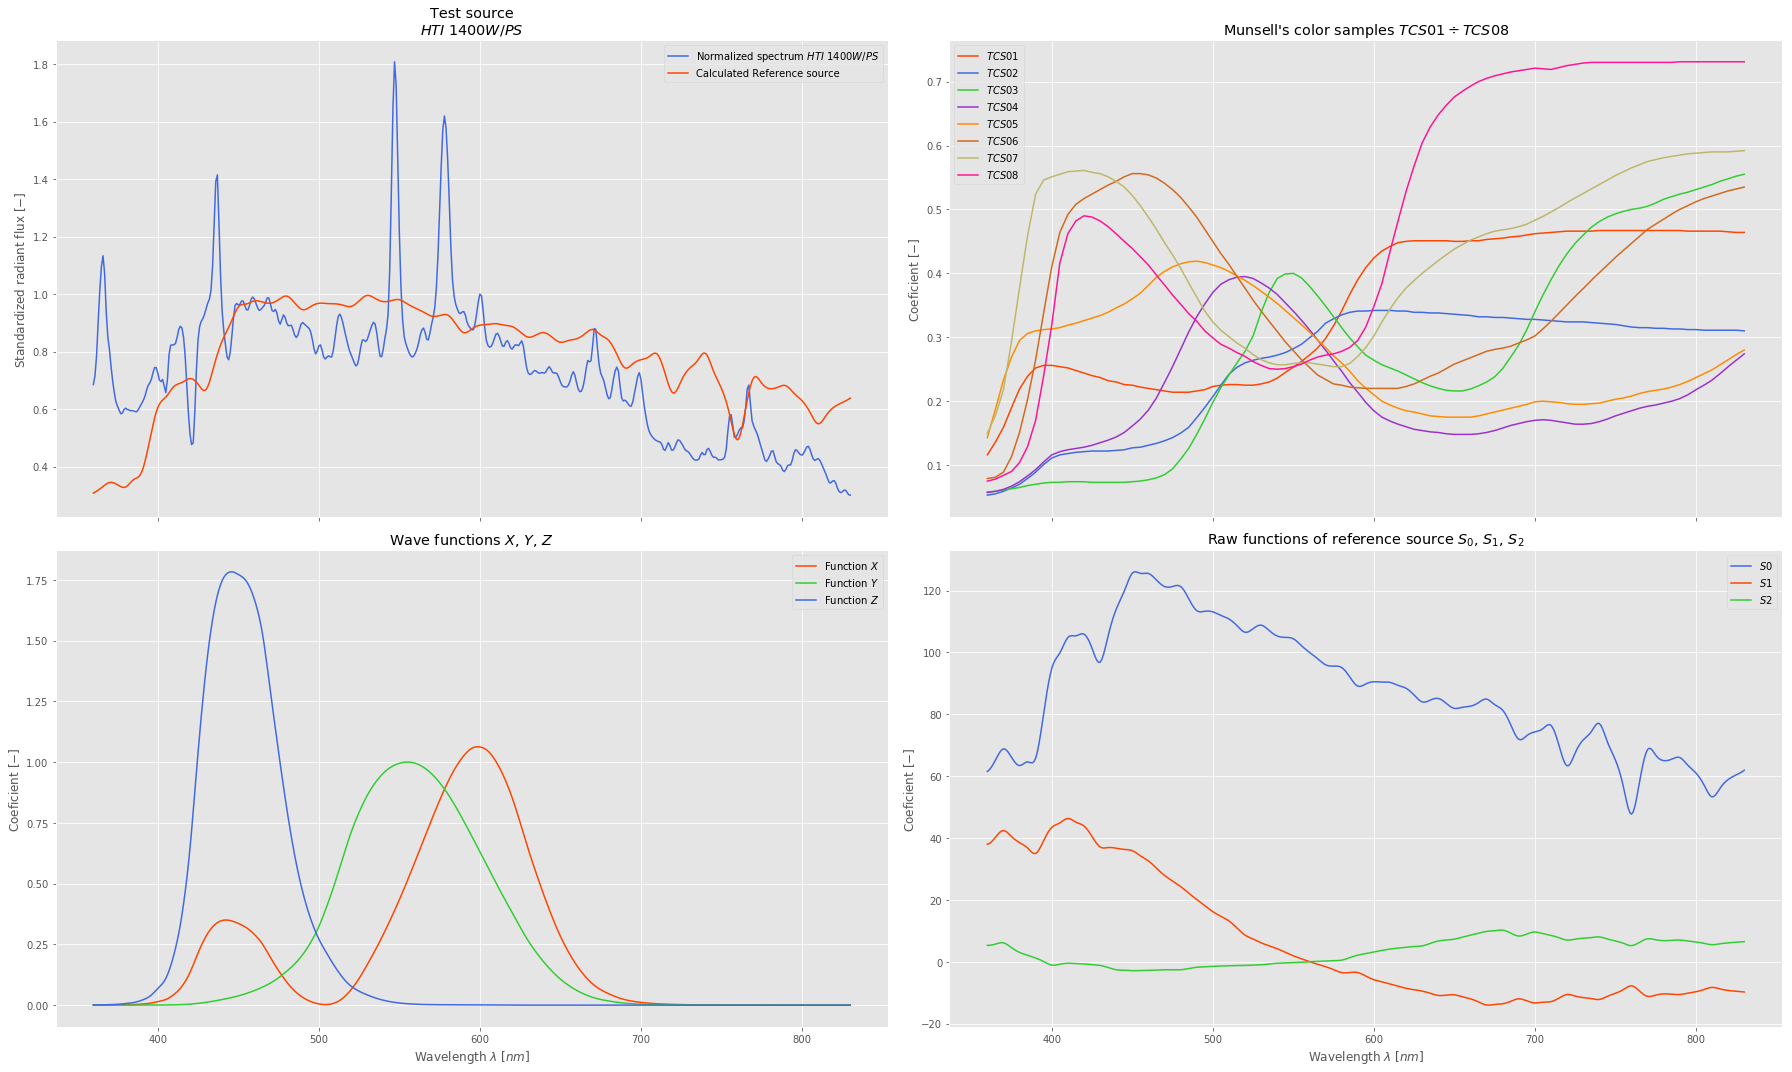

,lux,X,Y,Z,TCS01,TCS02,TCS03,TCS04,TCS05,TCS06,TCS07,TCS08,S0,S1,S2,Reference
wavelength,,,,,,,,,,,,,,,,
360,0.685456,0.000130,0.000004,0.000606,0.116,0.0530,0.0580,0.0570,0.1430,0.0790,0.1500,0.0750,61.500000,38.000000,5.300000,0.308006
361,0.715181,0.000146,0.000004,0.000681,0.120,0.0534,0.0582,0.0574,0.1518,0.0794,0.1554,0.0756,61.928794,38.141498,5.288841,0.311139
362,0.786428,0.000164,0.000005,0.000765,0.124,0.0538,0.0584,0.0578,0.1606,0.0798,0.1608,0.0762,62.543693,38.480333,5.333400,0.314525
363,0.904250,0.000184,0.000006,0.000860,0.128,0.0542,0.0586,0.0582,0.1694,0.0802,0.1662,0.0768,63.309196,38.968420,5.423539,0.318188
364,1.013561,0.000207,0.000006,0.000967,0.132,0.0546,0.0588,0.0586,0.1782,0.0806,0.1716,0.0774,64.189799,39.557671,5.549118,0.322149


In [8]:
Frames = [spectrum.wavelength,spectrum.lux,
          XYZ.X,XYZ.Y,XYZ.Z,
          Munsell.TCS01,Munsell.TCS02,Munsell.TCS03,Munsell.TCS04,
          Munsell.TCS05,Munsell.TCS06,Munsell.TCS07,Munsell.TCS08,
          Ref.S0,Ref.S1,Ref.S2,
          Reference]

Graphics = pd.concat(Frames, axis=1)
Graphics.rename(columns={0:'Reference'}, inplace=True)
Graphics = Graphics.set_index('wavelength')

#################################################################

f, ([ax1, ax3], [ax2, ax4]) = plt.subplots(2,2, sharex=True, figsize=(25, 15))

ax1.plot(wavelength,Graphics.lux,color='royalblue')
ax1.plot(wavelength,Graphics.Reference,color='orangered')
    
ax1.set_title('Test source\n$HTI$ $1400W/PS$')
#ax1.set_xlabel('Wavelength $\lambda$ $[nm]$')
ax1.set_ylabel('Standardized radiant flux $[-]$')
ax1.legend(['Normalized spectrum $HTI$ $1400W/PS$',
            'Calculated Reference source'])

ax2.plot(wavelength,Graphics.X,color='orangered')
ax2.plot(wavelength,Graphics.Y,color='limegreen')
ax2.plot(wavelength,Graphics.Z,color='royalblue')

ax2.set_title('Wave functions $X$, $Y$, $Z$')
ax2.set_xlabel('Wavelength $\lambda$ $[nm]$')
ax2.set_ylabel('Coeficient $[-]$')
ax2.legend(['Function $X$','Function $Y$','Function $Z$'])

ax3.plot(wavelength,Graphics.TCS01,color='orangered')
ax3.plot(wavelength,Graphics.TCS02,color='royalblue')
ax3.plot(wavelength,Graphics.TCS03,color='limegreen')
ax3.plot(wavelength,Graphics.TCS04,color='darkorchid')
ax3.plot(wavelength,Graphics.TCS05,color='darkorange')
ax3.plot(wavelength,Graphics.TCS06,color='chocolate')
ax3.plot(wavelength,Graphics.TCS07,color='darkkhaki')
ax3.plot(wavelength,Graphics.TCS08,color='deeppink')

#ax3.plot(wavelength,Graphics.TCS09)
#ax3.plot(wavelength,Graphics.TCS10)
#ax3.plot(wavelength,Graphics.TCS11)
#ax3.plot(wavelength,Graphics.TCS12)
#ax3.plot(wavelength,Graphics.TCS13)
#ax3.plot(wavelength,Graphics.TCS14)
#ax3.plot(wavelength,Graphics.TCS15)

ax3.set_title('Munsell\'s color samples $TCS01 \div TCS08$')
#ax3.set_xlabel('Wavelength $\lambda$ $[nm]$')
ax3.set_ylabel('Coeficient $[-]$')
ax3.legend(['$TCS01$', '$TCS02$', '$TCS03$', '$TCS04$',
            '$TCS05$', '$TCS06$', '$TCS07$', '$TCS08$',
            '$TCS09$', '$TCS10$', '$TCS11$', '$TCS12$',
            '$TCS13$', '$TCS14$', '$TCS14$'])

ax4.plot(wavelength,Graphics.S0,color='royalblue')
ax4.plot(wavelength,Graphics.S1,color='orangered')
ax4.plot(wavelength,Graphics.S2,color='limegreen')

ax4.set_title('Raw functions of reference source $S_0$, $S_1$, $S_2$')
ax4.set_xlabel('Wavelength $\lambda$ $[nm]$')
ax4.set_ylabel('Coeficient $[-]$')
ax4.legend(['$S0$','$S1$','$S2$'])

#figMng = plt.get_current_fig_manager()
#figMng.window.showMaximized()

plt.tight_layout()
plt.show()

Graphics.head(5)

<img src=https://cdn-images-1.medium.com/max/1200/0*mPc5j1btWBFz6YK7.jpg width="500">

[<img src=https://www.continuum.io/sites/all/themes/continuum/assets/images/logos/logo-horizontal-large.svg width="200">](https://www.continuum.io/ "Leading Open Data Science Platform Powered by Python")

___

<table style="width:100%" border="0">
<tr>

<td>
[<img src=https://www.python.org/static/community_logos/python-logo-master-v3-TM.png width="150">](https://www.python.org/ "Python is a widely used high-level script programming language")
</td>

<td>
[<img src=https://raw.githubusercontent.com/jupyter/nature-demo/master/images/jupyter-logo.png width="150">](http://jupyter.org/ "Interactive data science and scientific computing across all programming languages.")
</td>

<td>
[<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/SQLite370.svg/1280px-SQLite370.svg.png width="80">](https://www.sqlite.org/ "Self-contained, high-reliability, embedded, full-featured SQL database engine")
</td>

<td>
[<img src=http://pandas.pydata.org/_static/pandas_logo.png width="150">](http://pandas.pydata.org/ "Python Data Analysis Library")
</td>

<td>
[<img src=https://upload.wikimedia.org/wikipedia/en/thumb/5/56/Matplotlib_logo.svg/1280px-Matplotlib_logo.svg.png width="150">](http://matplotlib.org/ "Matplotlib is a Python 2D plotting library")
</td>

</tr>
</table>

&copy; Copyright: **BURDA Miroslav** 2017